In [14]:
import numpy as np
import pylab as plt
import pandas as pd
import tensorflow as tf
import pickle


def gload(gsname):
    with tf.io.gfile.GFile(gsname, "rb") as file:
        obj = pickle.load(file)
    return obj


def load_precomp(basedir):
    Ms = gload(f"{basedir}/Mlist")
    ks = gload(f"{basedir}/ks")
    return Ms, ks


def load(name):
    return load_precomp(f"gs://hml-public/dd/{name}")


Ms, ks = load("cifar10-resnet18k-p15-adam-reps")

## Simple Plot

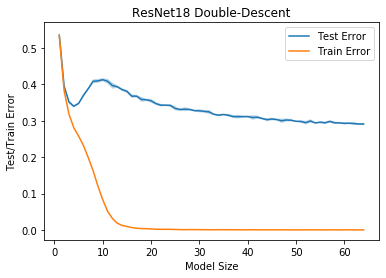

In [12]:
## data format:
## Ms[i]['Test Error'][s, epoch] : Test Error of model of size s, at epoch. For trial i (of 5 trials).

errs = np.array([M["Test Error"][:, -1] for M in Ms])

p = 0.15  # fraction of noise
errs = (
    1.0 - (1 - p) * (1 - errs) + errs * p / 9.0
)  # remap clean test error --> noisy test error.

stds = np.std(errs, axis=0)
mean = np.mean(errs, axis=0)
train_err = np.mean([M["Train Error"][:, -1] for M in Ms], axis=0)


fig, ax = plt.subplots()
ax.plot(ks, mean, label="Test Error")
ax.plot(ks, train_err, label="Train Error")
ax.fill_between(ks, mean - stds, mean + stds, alpha=0.3)
ax.set_xlabel("Model Size")
ax.set_ylabel("Test/Train Error")
ax.set_title("ResNet18 Double-Descent")
ax.legend()

## Fancier Plot

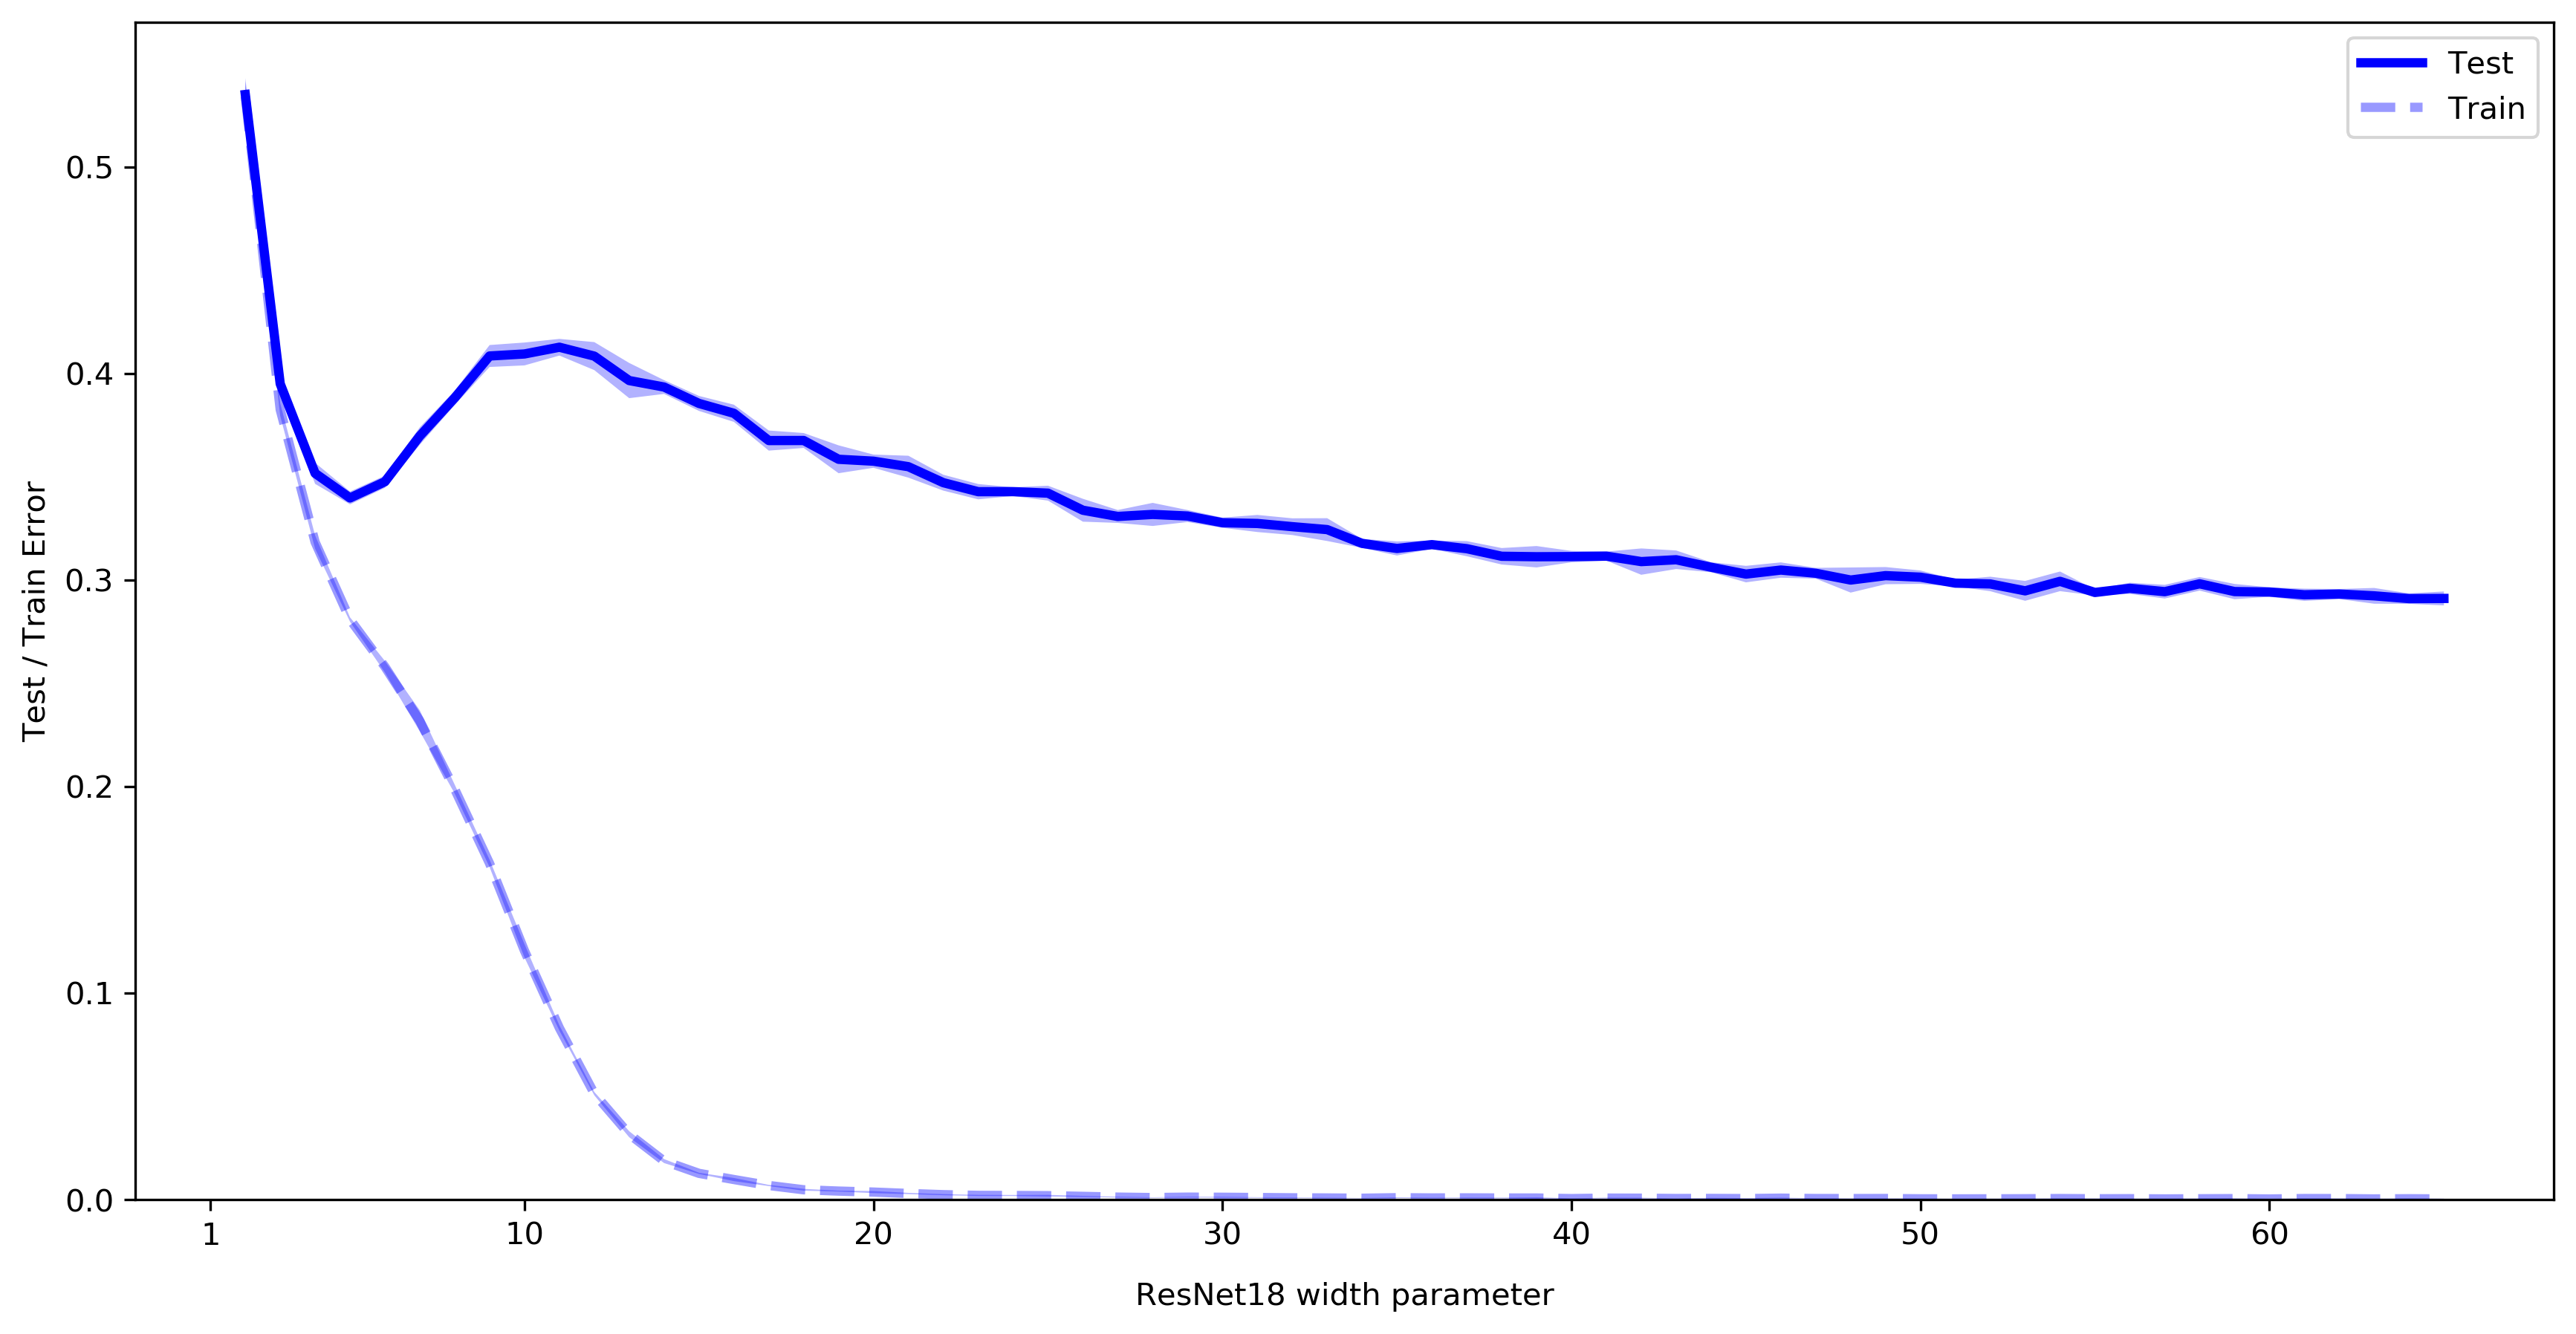

In [13]:
def plot(Ms, ks, savepath=None, noise_level=0.15, linewidth=3, marker_size=4):
    # Ms: List of the line plots for eg: if plotting three noise levels this has length 3

    # plt.style.reload_library()
    # plt.style.use('~/hml-common/mplstyles/twocol.mpl')

    fig, ax = plt.subplots(1, 1, figsize=(14, 7), dpi=300)

    p = noise_level
    errs_te = np.array([M["Test Error"][:, -1] for M in Ms])
    errs_te = 1.0 - (1 - p) * (1 - errs_te) + errs_te * p / 9.0  # noisy test
    stds_te = np.std(errs_te, axis=0)
    mean_te = np.mean(errs_te, axis=0)

    errs_tr = np.array([M["Train Error"][:, -1] for M in Ms])
    stds_tr = np.std(errs_tr, axis=0)
    mean_tr = np.mean(errs_tr, axis=0)

    ax.plot(ks, mean_te, "-", color="b", ms=marker_size, lw=linewidth, label="Test")
    ax.fill_between(ks, mean_te - stds_te, mean_te + stds_te, alpha=0.3, facecolor="b")

    ax.plot(ks, mean_tr, "--", color="b", lw=linewidth, alpha=0.4, label="Train")
    ax.fill_between(ks, mean_tr - stds_tr, mean_tr + stds_tr, alpha=0.3, facecolor="b")

    # X-axis
    q = np.arange(len(ks))
    x_idx = [q[0]] + list(q[9::10])
    x_steps = np.array(ks)[x_idx]
    x_labs = ["%d" % x for x in x_steps]
    ax.set_xticks(x_idx)
    ax.set_xticklabels(x_labs)
    ax.set_xlabel("ResNet18 width parameter")
    ax.xaxis.labelpad = 10

    ax.set_ylabel("Test / Train Error")
    ax.set_ylim(bottom=0.0, top=None)
    ax.legend(loc="upper right")

    plt.show()


plot(Ms, ks, savepath=None, noise_level=0.15, linewidth=3, marker_size=4)